## Overview

For this competition, you will be predicting a continuous target based on a number of feature columns given in the data. All of the feature columns, cat0 - cat9 are categorical, and the feature columns cont0 - cont13 are continuous.

@ebharucha - Aug 2021

### Import dependencies

In [ ]:
import numpy as np
import pandas as pd

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, StackingRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from keras.wrappers.scikit_learn import KerasRegressor

import seaborn as sns
from pandas_profiling import ProfileReport

import matplotlib.pyplot as plt
%matplotlib inline

import string
import pickle
from collections import Counter

import gc

import warnings
warnings.filterwarnings('ignore')

gc.collect()

### Load data

In [24]:
train_df = pd.read_csv('/kaggle/input/30-days-of-ml/train.csv')
test_df = pd.read_csv('/kaggle/input/30-days-of-ml/test.csv')
sample_submission = pd.read_csv("../input/30-days-of-ml/sample_submission.csv")

# All categorical columns
object_cols = [col for col in train_df.columns if train_df[col].dtype == "object"]

# All numerical columns
cont_cols = [col for col in train_df.columns if train_df[col].dtype != "object"]

train_df.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
0,1,B,B,B,C,B,B,A,E,C,...,0.400361,0.160266,0.310921,0.389470,0.267559,0.237281,0.377873,0.322401,0.869850,8.113634
1,2,B,B,A,A,B,D,A,F,A,...,0.533087,0.558922,0.516294,0.594928,0.341439,0.906013,0.921701,0.261975,0.465083,8.481233
2,3,A,A,A,C,B,D,A,D,A,...,0.650609,0.375348,0.902567,0.555205,0.843531,0.748809,0.620126,0.541474,0.763846,8.364351
3,4,B,B,A,C,B,D,A,E,C,...,0.668980,0.239061,0.732948,0.679618,0.574844,0.346010,0.714610,0.540150,0.280682,8.049253
4,6,A,A,A,C,B,D,A,E,A,...,0.686964,0.420667,0.648182,0.684501,0.956692,1.000773,0.776742,0.625849,0.250823,7.972260


### EDA

In [ ]:
profile = ProfileReport(train_df, explorative=True)
profile = profile.load("/kaggle/input/edarep/EDA.pp") 
profile

In [ ]:
train_df.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

### Feature engineering
Did not find much benefit utilizing the engineered features below

In [ ]:
# Count of alphabets (A ... O) in each row of categorical features
object_cols, cont_cols[1:-1]
# cat_row_counts = train_df[object_cols].apply(pd.Series.value_counts, axis=1)[list(string.ascii_uppercase)[:15]].fillna(0)
# cat_row_counts_test = test_df[object_cols].apply(pd.Series.value_counts, axis=1)[list(string.ascii_uppercase)[:15]].fillna(0)
with open('/kaggle/input/catrowcounts/cat_row_counts_full.pkl', 'rb') as pklfile:
    cat_row_counts_train = pickle.load(pklfile)
with open('/kaggle/input/catrowcountstest/cat_row_counts_test.pkl', 'rb') as pklfile:
    cat_row_counts_test = pickle.load(pklfile)

# Calculate letter frequency & weightage
def calc_cat_freq_weight(df, df_eng, object_cols):
    col_val_counts = [df[col].value_counts().to_dict() for col in object_cols]
    dicts = [col_val_counts[0],
            col_val_counts[1],
            col_val_counts[2],
            col_val_counts[3],
            col_val_counts[4],
            col_val_counts[5],
            col_val_counts[6],
            col_val_counts[7],
            col_val_counts[8],
            col_val_counts[9],
            ]
    c = Counter()
    for d in dicts:
        c.update(d)
    total = sum(c.values())
    weights = {key:val/total for key, val in c.items()}
    [df_eng.replace(letter, weights[letter], inplace=True) for letter in (string.ascii_uppercase)[:15]]
    [df_eng.rename(columns={col:f'{col}_'}, inplace=True) for col in object_cols]
    return(df_eng)

train_df_obj_eng = train_df[object_cols].copy()
train_df_obj_eng = calc_cat_freq_weight(train_df[object_cols], train_df_obj_eng, object_cols)
train_df_obj_eng = pd.concat([train_df_obj_eng, cat_row_counts_train], axis=1)

test_df_obj_eng = test_df[object_cols].copy()
test_df_obj_eng = calc_cat_freq_weight(test_df[object_cols], test_df_obj_eng, object_cols)
test_df_obj_eng = pd.concat([test_df_obj_eng, cat_row_counts_test], axis=1)

# Construct dataframe with engineered features    
def calc_mul_mean_std(df, df_eng):
    mult = pd.Series(np.array([1]*df.shape[0]))
    for col in df.columns:
        mult = mult * df[col]
    df_eng['cont_cols_mult'] = mult
    # Calculate mean,standard deviation for each row of continuous feature
    mean = df.mean(axis=1)
    std = df.std(axis=1)
    # Construct dataframe with engineered features
    df_eng['mean'] = mean
    df_eng['std'] = std
    return(df_eng)

train_df_cont_eng = pd.DataFrame()
train_df_cont_eng = calc_mul_mean_std(train_df[cont_cols[1:-1]], train_df_cont_eng)
train_df_cont_eng = pd.concat([train_df[cont_cols[1:-1]], train_df_cont_eng], axis=1)

test_df_cont_eng = pd.DataFrame()
test_df_cont_eng = calc_mul_mean_std(test_df[cont_cols[1:-1]], test_df_cont_eng)
test_df_cont_eng = pd.concat([test_df[cont_cols[1:-1]], test_df_cont_eng], axis=1)

# Consolidate into overall train & test engineered feature dataframes

train_df_eng = pd.concat([train_df_obj_eng, train_df_cont_eng], axis=1)
test_df_eng = pd.concat([test_df_obj_eng, test_df_cont_eng], axis=1)

### Create train, validate, test data

In [ ]:
cont_cols = cont_cols[1:-1]
object_cols_ = ['cat0_', 'cat1_', 'cat2_', 'cat3_', 'cat4_', 'cat5_', 'cat6_', 'cat7_', 'cat8_', 'cat9_']
alpha_cols = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O']
stats_cols = ['cont_cols_mult', 'mean', 'std']
data_cols = ['object_cols', 'object_cols_', 'cont_cols', 'alpha_cols', 'stats_cols']
print (data_cols)

# sub_cols = ['cat0_', 'cat1_', 'cat2_', 'cat3_', 'cat4_', 'cat5_', 'cat6_', 'cat7_',
#        'cat8_', 'cat9_', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K',
#        'L', 'M', 'N', 'O', 'mean', 'std']
# sub_cols = object_cols_ + stats_cols
sub_cols = stats_cols

# X = pd.concat([train_df.drop(columns=['id', 'target']), train_df_eng[sub_cols]], axis=1)
X = train_df.drop(columns=['id', 'target'])  # Note:  Keeping the training set vanilla, since did not observe much benefit with the engineered features
X_ = X.copy()
# X_test = pd.concat([test_df.drop(columns=['id']), test_df_eng[sub_cols]], axis=1)
X_test = test_df.drop(columns=['id'])
y = train_df.target

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)
X_train = X_train.reset_index(drop=True)
X_valid = X_valid.reset_index(drop=True)
# print (X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape)
print (f'X.columns = {X.columns}')

### Encode function

In [ ]:
def encodeFeatures(encode=True):
    if (encode):
        scaler = StandardScaler()
#         scaler = MinMaxScaler()
        column_trans = make_column_transformer(
            (OrdinalEncoder(), object_cols),
#             (scaler, cont_cols[1:-1]),
#             (scaler, X.columns),
#             remainder = scaler
            remainder='passthrough'
        ) 
        return(column_trans)
    else:
        return (None)

encode = True
column_trans = encodeFeatures(encode)

### Principal component Analysis (PCA)
Did not observe much benefit in reducing dimensionality

In [ ]:
def pcaData (data, var_perc):
  pca = PCA(n_components = var_perc)   # retain var_perc% of variance
  principalComponents_data = pca.fit_transform(data)
  return (principalComponents_data)

pca = False
if (pca):
    X_train_trans = column_trans.fit_transform(X_train)
    # X_train_trans = scaler.fit_transform(X_train_trans)
    pca_train = pcaData(X_train_trans, 0.95)

    X_valid_trans = column_trans.fit_transform(X_valid)
    # X_valid_trans = scaler.fit_transform(X_valid_trans)
    pca_valid = pcaData(X_valid_trans, 0.95)

    pca_train.shape, pca_valid.shape
else:
    print ('Not performing PCA')

### Initialize models
Hyperparameters set mostly by trial and error

In [27]:
# Without GPU

lr_model = LinearRegression()

lgb_params1 = {
    'objective': 'regression_l2',
    'metric' : 'rmse',
    'random_state': 0,
    'learning_rate' : 0.05, # default = 0.1
    'num_iterations' : 1200, # default = 100
    'num_leaves' : 31, # default = 31
    'max_depth' : 6, # default = -1
    'min_child_samples' : 1000, # default = 20
    'max_bin' : 255, # default = 255
    'colsample_bytree' : 0.15, # default = 1.0
    'reg_alpha' : 25, # default = 0
    'reg_lambda' : 0, # default = 0
    'min_split_gain' : 0, # default = 0|
    'boosting_type' : 'gbdt'
    }
lgb_model1 = lgb.LGBMRegressor(**lgb_params1)

xgb_params1 = {
    'random_state': 0,
    'learning_rate' : 0.08, # default = 0.3
    'n_estimators' : 4700, # default = 100
    'max_depth' : 3, # default = 6
    'min_child_weight' : 7, # default = 1
    'colsample_bytree' : 0.12, #default = 1
    'reg_alpha' : 25, # default = 0
    'reg_lambda' : 7, # default = 0/1
    }
xgb_model1 = XGBRegressor(**xgb_params1)

In [26]:
# With GPU

gpu_lgb_params1 = {
    'objective': 'regression_l2',
    'metric' : 'rmse',
    'device' : "gpu",
    'gpu_platform_id' : 0,
    'gpu_device_id': 0,
    'random_state': 0,
    'learning_rate' : 0.05, # default = 0.1
    'num_iterations' : 1200, # default = 100
    'num_leaves' : 31, # default = 31
    'max_depth' : 6, # default = -1
    'min_child_samples' : 1000, # default = 20
    'max_bin' : 255, # default = 255
    'colsample_bytree' : 0.15, # default = 1.0
    'reg_alpha' : 25, # default = 0
    'reg_lambda' : 0, # default = 0
    'min_split_gain' : 0, # default = 0
    'boosting_type' : 'gbdt'
    }
gpu_lgb_model1 = lgb.LGBMRegressor(**gpu_lgb_params1)

gpu_lgb_params2 = {
    'objective': 'regression_l2',
    'metric' : 'rmse',
    'device' : "gpu",
    'gpu_platform_id' : 0,
    'gpu_device_id': 0,
    'random_state': 0,
    }
gpu_lgb_model2 = lgb.LGBMRegressor(**gpu_lgb_params2)

gpu_xgb_params1 = {
    'tree_method':'gpu_hist',
    'gpu_id': 0,
    'predictor': 'gpu_predictor',
    'random_state': 0,
    'learning_rate' : 0.08, # default = 0.3
    'n_estimators' : 4700, # default = 100
    'max_depth' : 3, # default = 6
    'min_child_weight' : 7, # default = 1
    'colsample_bytree' : 0.12, #default = 1
    'reg_alpha' : 25, # default = 0
    'reg_lambda' : 7, # default = 0/1
    }
gpu_xgb_model1 = XGBRegressor(**gpu_xgb_params1)

gpu_xgb_params2 = {
    'tree_method':'gpu_hist',
    'gpu_id': 0,
    'predictor': 'gpu_predictor',
    'random_state': 0
    }
gpu_xgb_model2 = XGBRegressor(**gpu_xgb_params2)

(24,)
Epoch 1/5
3750/3750 [==============================] - 8s 2ms/step - loss: 3.8403 - root_mean_squared_error: 1.8422 - val_loss: 0.5544 - val_root_mean_squared_error: 0.7446
Epoch 2/5
3750/3750 [==============================] - 7s 2ms/step - loss: 0.5603 - root_mean_squared_error: 0.7485 - val_loss: 0.5491 - val_root_mean_squared_error: 0.7410
Epoch 3/5
3750/3750 [==============================] - 8s 2ms/step - loss: 0.5500 - root_mean_squared_error: 0.7416 - val_loss: 0.5494 - val_root_mean_squared_error: 0.7412
Epoch 4/5
3750/3750 [==============================] - 7s 2ms/step - loss: 0.5544 - root_mean_squared_error: 0.7446 - val_loss: 0.5515 - val_root_mean_squared_error: 0.7427
Epoch 5/5
3750/3750 [==============================] - 7s 2ms/step - loss: 0.5511 - root_mean_squared_error: 0.7424 - val_loss: 0.5516 - val_root_mean_squared_error: 0.7427
RMSE for Model 1 = 0.7438929468761204


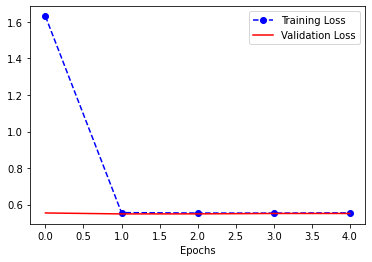

In [25]:
# Deep learning models

def plot_hist(history):
  history_dict=history.history
  loss_values = history_dict['loss']
  val_loss_values=history_dict['val_loss']
  plt.xlabel('Epochs')
  plt.plot(loss_values, color='Blue', linestyle='dashed', marker='o', label='Training Loss')
  plt.plot(val_loss_values,color='Red', label='Validation Loss')
  plt.legend()
  plt.show()

def dl_model1(X, y):
    name = 'Model 1'

    input_shape = X[0].shape
    print (input_shape)

    model = Sequential()
    model.add(Dense(16, input_shape=input_shape, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(8, activation='relu'))
    model.add(Dropout(0.2))
#     model.add(Dense(16, activation='relu'))
#     model.add(Dropout(0.2))
    model.add(Dense(1,activation='linear'))
    model.compile(Adam(lr=0.01), 
                loss='mse',
                metrics=[RootMeanSquaredError()])
    
    # Runs model for 50 iterations and assigns this to 'history'
    history = model.fit(X, y, epochs = 5, batch_size=64, validation_split = 0.2, verbose=1)

    y_pred = model.predict(X)
    print (f'RMSE for {name} = {mean_squared_error(y, y_pred, squared=False)}')

    # Plot Training & Validation Loss
    plot_hist(history)

    return(model)

iters = 1

for iter in range(iters):
    model_1 = dl_model1(column_trans.fit_transform(X), y)
#     model_1 = dl_model1(np.array(X), y)


### Set up pipeline & run cross validation
Encode categorical features and run 5 fold cross validation
Use Stacking Ensemble, with LightGBM & XGBoost as Base-Models and LinearRegression as the Meta-Model

In [28]:
GPU = True
# GPU = False

def pipeline(column_trans, model, model_label, X, y, encode, cv=5, pca=False):
    if (encode):
        if (pca):
            pipe = make_pipeline(
                column_trans,
                PCA(n_components = 0.95),
                model
            )
        else:
            pipe = make_pipeline(
                column_trans,
                model
            )
    else:
        pipe = make_pipeline(
                model
            )
        
    scores = -1 * cross_val_score(pipe, X, y, cv=cv, scoring='neg_root_mean_squared_error')
    print (f'Mean score for {model_label} = {scores.mean()}')

if (GPU):
    estimators = [
        ('gpu_lgb1', gpu_lgb_model1),
        ('gpu_xgb1', gpu_xgb_model1)
    ]
    lgb_model = gpu_lgb_model1
    xgb_model = gpu_xgb_model1
else:
    estimators = [
        ('lgb1', lgb_model1),
        ('xgb1', xgb_model1)
    ]
    lgb_model = lgb_model1
    xgb_model = lgb_model1

stackreg = StackingRegressor(
    estimators=estimators,
    final_estimator=lr_model
)


for model, model_label in zip([lgb_model, xgb_model, stackreg],['LightGBM','XGBoost','Stacking Regressor']):
    pipeline(column_trans, model, model_label, X, y, encode=True, cv=5, pca=False)

Mean score for LightGBM = 0.7185742402269343
Mean score for XGBoost = 0.7176847001404619
Mean score for Stacking Regressor = 0.7175107054086196


### Predict
Use CPU for prediction - gives better results than GPU

In [30]:
estimators = [
        ('lgb1', lgb_model1),
        ('xgb1', xgb_model1)
    ]
lgb_model = lgb_model1
xgb_model = lgb_model1

stackreg = StackingRegressor(
    estimators=estimators,
    final_estimator=lr_model
)

stackreg

StackingRegressor(estimators=[('lgb1',
                               LGBMRegressor(colsample_bytree=0.15,
                                             learning_rate=0.05, max_bin=255,
                                             max_depth=6, metric='rmse',
                                             min_child_samples=1000,
                                             min_split_gain=0,
                                             num_iterations=1200,
                                             objective='regression_l2',
                                             random_state=0, reg_alpha=25,
                                             reg_lambda=0)),
                              ('xgb1',
                               XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=...
                                            interaction_constraints=None,
               

In [31]:
def pred (column_trans, model, X, y, XValid, encode, pca=False):
    if (encode):
        if (pca):
            pipe = make_pipeline(
                column_trans,
                PCA(n_components = 0.95),
                model
            )
        else:
            pipe = make_pipeline(
                column_trans,
                model
            )
    else:
        pipe = make_pipeline(
                model
            )
    pipe.fit(X, y)
    preds = pipe.predict(XValid)
    return (preds)

models = [stackreg]
predictions = [pred(column_trans, model, X, y, X_test, encode, pca=False) for model in models]

### Prepare submission

In [32]:
# Take mean if using predictions from 2 models as the final output
# mean_preds = np.concatenate([predictions[0].reshape(-1,1), predictions[1].reshape(-1,1)], axis=1).mean(axis=1)
# sample_submission.target = mean_preds

# If using predictions from a single model (including stacking) as a final output
sample_submission.target = predictions[0]
sample_submission.to_csv("submissionXX_stackreg.csv", index=False)

### Hyperparameter tuning
Didn't explore tuning using optuna in much detail.  Primarily used trial and error for hyperparameter settings as reflected in models above.

In [ ]:
# Hyperparameter tuning

import optuna

def objective(trial):
    learning_rate = trial.suggest_float("learning_rate", 0.02, 0.1, log=True)
    num_iterations = trial.suggest_int('num_iterations', 1000, 2000)
#     num_leaves = trial.suggest_int('num_leaves', 2, 256),
#     max_depth = trial.suggest_int('max_depth', 3, 10)
#     min_child_samples = trial.suggest_int('min_child_samples', 5, 100)
#     feature_fraction = trial.suggest_uniform('feature_fraction', 0.4, 1.0)
#     colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
#     reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 10.0)
#     reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 10.0)
#     bagging_fraction = trial.suggest_uniform('bagging_fraction', 0.4, 1.0)
#     bagging_freq = trial.suggest_int('bagging_freq', 1, 7)
    lgb_params = {
        'objective': 'regression_l2',
        'metric' : 'rmse',
        'device' : "gpu",
        'gpu_platform_id' : 0,
        'gpu_device_id': 0,
        'random_state': 0,
        'learning_rate' : learning_rate, # default = 0.1
        'num_iterations' : num_iterations, # default = 100
        'num_leaves' : 31, # default = 31
        'max_depth' : 6, # default = -1
        'min_child_samples' : 1000, # default = 20
        'max_bin' : 255, # default = 255
        'colsample_bytree' : 0.15, # default = 1.0
        'reg_alpha' : 25,
        'reg_lambda' : 0,
        'min_split_gain' : 0, # default = 0
#         'feature_fraction' : feature_fraction,
#         'bagging_fraction' : bagging_fraction,
#         'bagging_freq' : bagging_freq,
        'boosting_type' : 'gbdt'
    }
    lgb_model = lgb.LGBMRegressor(**lgb_params)
    
    learning_rate = trial.suggest_float("learning_rate", 1e-2, 0.25, log=True)
    reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
    reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
    subsample = trial.suggest_float("subsample", 0.1, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.1, 1.0)
    xgb_params = {
    'tree_method':'gpu_hist',
    'gpu_id': 0,
    'predictor': 'gpu_predictor',
    'random_state': 0,
    'n_estimators' : 10000, # default = 100
    'max_depth' : 3, # default = 6
    'min_child_weight' : 7, # default = 1
    'learning_rate' : learning_rate,
    'reg_lambda' : reg_lambda,
    'reg_alpha' : reg_alpha,
    'subsample' : subsample,
    'colsample_bytree' : colsample_bytree,
    }
    xgb_model = XGBRegressor(**xgb_params)
    
    model = lgb_model
#     model = xgb_model
    
    cv = 2
    pca = False
    
    if (encode):
        if (pca):
            pipe = make_pipeline(
                column_trans,
                PCA(n_components = 0.95),
                model
            )
        else:
            pipe = make_pipeline(
                column_trans,
                model
            )
    else:
        pipe = make_pipeline(
                model
            )
        
    scores = -1 * cross_val_score(pipe, X, y, cv=2, scoring='neg_root_mean_squared_error')
    return (scores.mean())


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)